In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
from scipy.optimize import curve_fit
from copy import deepcopy
import matplotlib
%matplotlib inline

確率密度分布の推移を求める

状態名と遷移過程と半減期をインプット

分解しかしないパターンを実装した

数密度に左右されるような過渡状態を持つ場合、別のコードが必要

吸収スペクトルの時間変化から各種パラメータを推定する部分は、計算量が爆発するので、GoogleColaboratoryで実行するべき。

In [2]:
state_numbers = {
    "A": 0, #   状態名:通し番号
    "B": 1,
    "C": 2,
    "D": 3,
    "E": 4,
}

states_graph = [
    ("A", "B", float("inf"), 1, True),# 遷移前の状態, 遷移後の状態, 遷移前の状態の寿命, 数密度何倍になるか,　遷移先の状態は光励起直後か
    ("B", "C", 2.5, 1, False),
    ("B", "D", 0.5, 1, False),
    ("D", "E", 0.5, 1, False),
]

bins = 10**4
before_lay_time_range = 1
after_lay_time_range = 9
lay_width_time_range = 0.25
time_range = before_lay_time_range + after_lay_time_range

In [3]:
lay_d = np.exp(-(np.arange(bins) - bins*0.1)**2/(bins*lay_width_time_range/time_range)**2)
lay_d /= np.sum(lay_d)

tl = [0.0]*len(state_numbers)
dp = [[0.0]*bins for _ in range(len(state_numbers))]

dp_index_graph = [[] for _ in range(len(state_numbers))]
lay_TFs = [False]*len(state_numbers)
for s1, s2, T, amp, lay_TF in states_graph:
    dp_index_graph[state_numbers[s1]].append((state_numbers[s2], T, amp))
    lay_TFs[state_numbers[s2]] = lay_TF
    if lay_TF:
        tl[state_numbers[s1]] = 1.0 # 初期密度が0ではない場合の値の代入。本当は、光への感度に比例した値を入れる必要がある


for t in range(bins):
    for i in range(len(dp_index_graph)):#   遷移元ループ
        for j, T, amp in dp_index_graph[i]:#    遷移先ループ
            if lay_TFs[j]:  #   指定された遷移先が光励起直後だった場合(指定された遷移元が入射前の定常状態だった場合)
                tl[i] -= lay_d[t]
                tl[j] += amp*lay_d[t]
            else:
                delta = tl[i] * (1.0 - np.exp(-(time_range/bins)/T))
                tl[i] -= delta
                tl[j] += amp*delta

            dp[i][t] = tl[i]
            dp[j][t] = tl[j]

0.0022567583513024977 0.9999999999999999


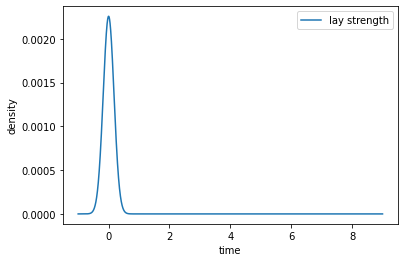

In [4]:
print(np.max(lay_d), np.sum(lay_d))
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
plt.plot(t, lay_d, label="lay strength")
plt.xlabel("time")
plt.ylabel("density")
plt.legend()
plt.savefig("result.png")

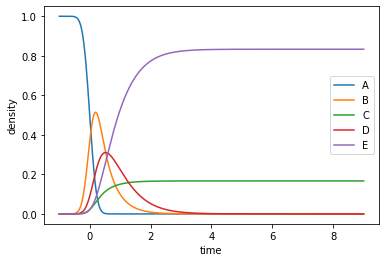

In [5]:
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
for state in state_numbers:
    plt.plot(t, dp[state_numbers[state]], label=state)
plt.xlabel("time")
plt.ylabel("density")
plt.legend()
plt.savefig("result.png")

In [6]:
#　各過渡状態が持つ吸光度を導入し、すべての状態のミックスの吸光度の時間変化を計算する
absorbance_dic = {
    "A":None,
    "B":None,
    "C":None,
    "D":None,
    "E":None
}
def gaussian_arr_creator(mu, sigma, max_density=1, ramda_lst=[i for i in range(200, 1000)]):
    ramda_arr = np.array(ramda_lst)
    return ramda_arr, max_density*np.exp(-(ramda_arr - mu)**2/(2*sigma**2))

ramda_arr, A_arr = gaussian_arr_creator(mu=350, sigma=10, max_density=0.2)
ramda_arr, B_arr = gaussian_arr_creator(mu=700, sigma=10, max_density=1.0)
ramda_arr, C_arr = gaussian_arr_creator(mu=600, sigma=10, max_density=0.5)
ramda_arr, D_arr = gaussian_arr_creator(mu=400, sigma=10, max_density=0.2)
ramda_arr, E_arr = gaussian_arr_creator(mu=300, sigma=10, max_density=0.1)
absorbance_dic["A"] = A_arr
absorbance_dic["B"] = B_arr
absorbance_dic["C"] = C_arr
absorbance_dic["D"] = D_arr
absorbance_dic["E"] = E_arr

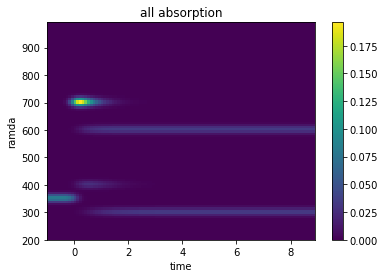

In [7]:
X, Y = 100, 100 #   X,Y軸のグリッド数
t = (np.arange(bins) - bins*before_lay_time_range/time_range)/bins*time_range
t_grid, ramda_grid = np.meshgrid(t[::max(1, len(t)//X)], ramda_arr[::max(1, len(ramda_arr)//Y)])

exist_colorbar = False
abs_sum_arr = None
for name in state_numbers:
    if name in absorbance_dic:
        abs_arr = np.outer(absorbance_dic[name][::max(1, len(ramda_arr)//X)], dp[state_numbers[name]][::max(1, len(t)//Y)])

        #plt.pcolor(abs_arr)
        plt.pcolor(t_grid, ramda_grid, abs_arr[:-1,:-1])
        plt.xlabel("time")
        plt.ylabel("ramda")
        plt.title(name)
        if not exist_colorbar:
            plt.colorbar()
            exist_colorbar = True
        plt.savefig("absorption"+name+".png")
        if abs_sum_arr is None:
            abs_sum_arr = abs_arr
        else:
            abs_sum_arr += abs_arr
        

plt.pcolor(t_grid, ramda_grid, abs_sum_arr[:-1,:-1])
plt.xlabel("time")
plt.ylabel("ramda")
plt.title("all absorption")
plt.savefig("all absorption.png")

フィッティングには　SciPyのcurve_fitでうまくいかなかったので、MCMCでパラメータの確率分布を求めるバージョンを試す
MCMC用の仮想環境をローカルに作って、適用する

Abs{λ)=Σ_t=1^100 absorption(λ, t) でピークの波長と幅を決める
scipy でAbs{λ)をフィッティング、ピーク位置とピーク強度パラメータと幅パラメータを得る

各ピーク強度の時間変化を決める。
ピーク位置パラメータと幅パラメータを既知の値として使いつつ、フィッティングしてピーク強度パラメータを出力する

ピーク強度の時間変化(規格化済み)の内積を取り、
内積が大きい組み合わせから「指定された過渡状態の数」になるまで同期している組み合わせを統合する

各過渡状態の遷移グラフと時間数密度分布(正規化)を計算

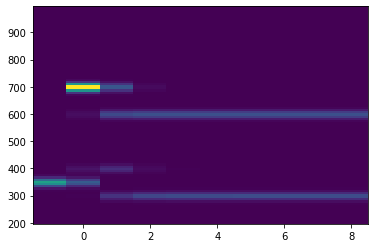

In [8]:
observed_t = t[::len(t)//10]
observed_ramda = ramda_arr[::len(ramda_arr)//100]   #   前処理して均した分布を入力する　要素数100程度が良いかと
observed_t_grid, observed_ramda_grid = np.meshgrid(observed_t, observed_ramda)
observed_absorption = deepcopy(abs_sum_arr[::max(1, len(abs_sum_arr[0])//len(observed_ramda)), ::max(1, len(abs_sum_arr[0])//len(observed_t))])

plt.pcolor(observed_t_grid, observed_ramda_grid, observed_absorption)

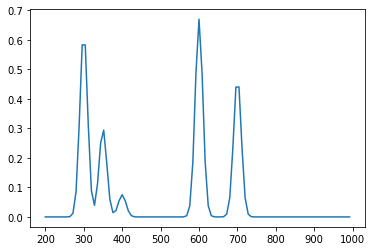

In [9]:
absorption_distribution = np.sum(observed_absorption, axis=1)
plt.plot(observed_ramda, absorption_distribution)

In [10]:
#   上の吸収スペクトルの時間積分？のピーク波長と半値幅を知りたい。のでscipyのcurve_fitを試す
ramda_min, ramda_max, d = observed_ramda[0], observed_ramda[-1], observed_ramda[1] - observed_ramda[0]
def func(observed_ramda, a1t, a2t, a3t, a4t, a5t, mu1, mu2, mu3, mu4, mu5, sigma1, sigma2, sigma3, sigma4, sigma5):
    arr1 = a1t*np.exp(-(np.arange(ramda_min, ramda_max+d, d) - mu1)**2/(2*sigma1**2))
    arr2 = a2t*np.exp(-(np.arange(ramda_min, ramda_max+d, d) - mu2)**2/(2*sigma2**2))
    arr3 = a3t*np.exp(-(np.arange(ramda_min, ramda_max+d, d) - mu3)**2/(2*sigma3**2))
    arr4 = a4t*np.exp(-(np.arange(ramda_min, ramda_max+d, d) - mu4)**2/(2*sigma4**2))
    arr5 = a5t*np.exp(-(np.arange(ramda_min, ramda_max+d, d) - mu5)**2/(2*sigma5**2))   
    return arr1 + arr2 + arr3 + arr4 + arr5
(a1t, a2t, a3t, a4t, a5t, mu1, mu2, mu3, mu4, mu5, sigma1, sigma2, sigma3, sigma4, sigma5), t = curve_fit(func, observed_ramda, absorption_distribution)
(a1t, a2t, a3t, a4t, a5t, mu1, mu2, mu3, mu4, mu5, sigma1, sigma2, sigma3, sigma4, sigma5)
# scipy.curve_fit が機能していない。変数が多すぎるのか、関数が複雑すぎるのか 仕方がないのでMCMCを使う

c:\Users\honka\OneDrive\ドキュメント\GitHub\JupyterProjects\absorption_time_change\.fit_by_mcmc\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

PyMC3を使うときは、ローカルで実行すると死ぬほど時間がかかるのでGoogleColaboratoryを使うことを推奨。警告とかでないし。

In [11]:
import pymc3 as pm

In [12]:
with pm.Model() as gaussian_fitting_model:
    #   観測変数をモデルに導入
    absorption = pm.Data('absorption', list(absorption_distribution))
    ramda = pm.Data('ramda', list(observed_ramda))

    #   ピークの幅には、共通の変数を充てる。共通の変数の事前分布
    w = pm.Uniform("w", lower=0, upper=200)

    #   ピークの波長の事前分布
    m1 = pm.Normal('m1', mu=300, sigma=20)
    m2 = pm.Normal('m2', mu=350, sigma=20)
    m3 = pm.Normal('m3', mu=400, sigma=20)
    m4 = pm.Normal('m4', mu=600, sigma=20)
    m5 = pm.Normal('m5', mu=700, sigma=20)

    #   ピークの高さの事前分布
    a1 = pm.Normal('a1', mu=0.55, sigma=0.1)
    a2 = pm.Normal('a2', mu=0.3, sigma=0.1)
    a3 = pm.Normal('a3', mu=0.1, sigma=0.1)
    a4 = pm.Normal('a4', mu=0.67, sigma=0.1)
    a5 = pm.Normal('a5', mu=0.45, sigma=0.1)
    
    #   吸収スペクトル(すべての時間で加算)を表す関数の定義
    g1 = a1*np.exp((-(m1-ramda)**2/w**2))
    g2 = a2*np.exp((-(m2-ramda)**2/w**2))
    g3 = a3*np.exp((-(m3-ramda)**2/w**2))
    g4 = a4*np.exp((-(m4-ramda)**2/w**2))
    g5 = a5*np.exp((-(m5-ramda)**2/w**2))
    g = g1 + g2 + g3 + g4 + g5
    
    obs = pm.Normal('obs', mu=g, sigma=0.01, observed=absorption)  #   尤度関数 Normal
    trace = pm.sample(2000, target_accept=0.95)  #   実験部分
    pm.plot_trace(trace) #   プロット

'\nwith pm.Model() as gaussian_fitting_model:\n    #   観測変数をモデルに導入\n    absorption = pm.Data(\'absorption\', list(absorption_distribution))\n    ramda = pm.Data(\'ramda\', list(observed_ramda))\n\n    #   ピークの幅には、共通の変数を充てる。共通の変数の事前分布\n    w = pm.Uniform("w", lower=0, upper=200)\n\n    #   ピークの波長の事前分布\n    m1 = pm.Normal(\'m1\', mu=300, sigma=20)\n    m2 = pm.Normal(\'m2\', mu=350, sigma=20)\n    m3 = pm.Normal(\'m3\', mu=400, sigma=20)\n    m4 = pm.Normal(\'m4\', mu=600, sigma=20)\n    m5 = pm.Normal(\'m5\', mu=700, sigma=20)\n\n    #   ピークの高さの事前分布\n    a1 = pm.Normal(\'a1\', mu=0.55, sigma=0.1)\n    a2 = pm.Normal(\'a2\', mu=0.3, sigma=0.1)\n    a3 = pm.Normal(\'a3\', mu=0.1, sigma=0.1)\n    a4 = pm.Normal(\'a4\', mu=0.67, sigma=0.1)\n    a5 = pm.Normal(\'a5\', mu=0.45, sigma=0.1)\n    \n    #   吸収スペクトル(すべての時間で加算)を表す関数の定義\n    g1 = a1*np.exp((-(m1-ramda)**2/w**2))\n    g2 = a2*np.exp((-(m2-ramda)**2/w**2))\n    g3 = a3*np.exp((-(m3-ramda)**2/w**2))\n    g4 = a4*np.exp((-(m4-ramda)**2/

In [13]:
tmp = None
with gaussian_fitting_model:
    tmp = pm.summary(trace)
tmp

'\ntmp = None\nwith gaussian_fitting_model:\n    tmp = pm.summary(trace)\ntmp\n'

In [14]:
with gaussian_fitting_model:
    pm.plot_posterior(trace)

'\nwith gaussian_fitting_model:\n    pm.plot_posterior(trace)\n'

In [15]:
pram1, pram2, pram3, pram4, pram5 = 300, 350, 400, 600, 700
w = 10

In [16]:
peak_arr1 = np.exp(-(observed_ramda - pram1)**2/w)
peak_arr2 = np.exp(-(observed_ramda - pram2)**2/w)
peak_arr3 = np.exp(-(observed_ramda - pram3)**2/w)
peak_arr4 = np.exp(-(observed_ramda - pram4)**2/w)
peak_arr5 = np.exp(-(observed_ramda - pram5)**2/w)

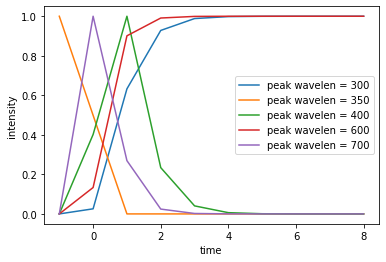

In [17]:
ats, prams_2_intensity = [], {}
prams = [pram1, pram2, pram3, pram4, pram5]
for i, time in enumerate(observed_t):
    absorption_at_the_time = observed_absorption[:,i]
    def integrate_peaks(observed_ramda, a1t, a2t, a3t, a4t, a5t):
        return a1t*peak_arr1 + a2t*peak_arr2 + a3t*peak_arr3 + a4t*peak_arr4 + a5t*peak_arr5
    (a1t, a2t, a3t, a4t, a5t), t = curve_fit(integrate_peaks, observed_ramda, absorption_at_the_time)
    ats.append([a1t, a2t, a3t, a4t, a5t])
ats = np.array(ats)
for i in range(len(ats[0])):
    peak_wavelenth = "peak wavelen = " + str(prams[i])
    ats[:,i] /= np.max(ats[:,i])
    prams_2_intensity[prams[i]] = ats[:,i]
    plt.plot(observed_t, ats[:,i], label=peak_wavelenth)
plt.xlabel("time")
plt.ylabel("intensity")
plt.legend()

In [18]:
states_with_peak_length = {
          350:"init_A", # ピーク波長をキー、状態を値に持つ
          700:"B",
          400:"C",
          600:"BASE_D",
          300:"BASE_E",
}
densities = {
    "init_A":None,
    "B":None,
    "C":None,
    "BASE_D":None,
    "BASE_E":None,
}

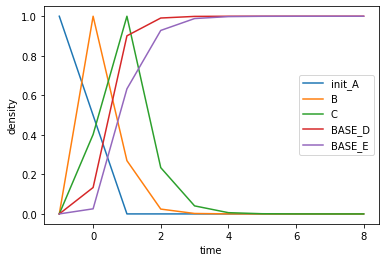

In [19]:
for peak_lenth in states_with_peak_length:
    state_name = states_with_peak_length[peak_lenth]
    if densities[state_name] is None:
        densities[state_name] = prams_2_intensity[peak_lenth]
    else:
        densities[state_name] += prams_2_intensity[peak_lenth]
        densities[state_name] /= np.max(densities[state_name])
for state_name in densities:
    density = densities[state_name]
    plt.plot(observed_t, density, label=state_name)
plt.xlabel("time")
plt.ylabel("density")
plt.legend()

ここから、可能なら、機械的に各状態の寿命(内生変数)と遷移経路(内生変数)を推定する方法を実装